In [1]:
import jax
import optax
import haiku as hk
import jax.numpy as jnp
from tqdm import tqdm
from gat import GAT
from data import get_cora_dataset
from train import Batch, TrainingState

# Training config
SEED = 42
NUM_CLASSES = 7
MAX_STEPS = 1000
PATIENCE = 100

# GAT config
GAT_LAYERS = 2
GAT_HEADS = [8, 1]
GAT_FEATURES = [8, NUM_CLASSES]
DROPOUT = 0.6

/Users/luca/.miniconda3/envs/jax_dev/lib/python3.10/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))


In [2]:
def gat_fn(batch: Batch, is_training: bool = True, return_att_coeffs: bool = False) -> jnp.ndarray:
    gat = GAT(
        num_layers=2,
        num_heads=[8, 1],
        num_features=[8, NUM_CLASSES],
        dropout=0.6
    )

    return gat(batch.nodes_features, batch.connectivity_mask, is_training, return_att_coeffs)

In [3]:
gat = hk.transform(gat_fn)
optimiser = optax.adam(5e-3)

In [4]:
def loss_fn(params: hk.Params, batch: Batch, rng) -> jnp.ndarray:
    """Cross-entropy classification loss, regularised by L2 weight decay"""
    batch_size = len(batch.node_indices)
    logits = gat.apply(params, rng, batch, is_training=True)[0].take(batch.node_indices, axis=0)
    targets = jax.nn.one_hot(batch.labels.take(batch.node_indices), NUM_CLASSES)

    log_likelihood = jnp.sum(targets * jax.nn.log_softmax(logits, axis=-1))
    l2_regulariser = 0.5 * sum(jnp.sum(jnp.square(p)) for p in jax.tree_util.tree_leaves(params))
    return -log_likelihood / batch_size + 5e-4 * l2_regulariser

@jax.jit
def update(state: TrainingState, batch: Batch):
    rng, new_rng = jax.random.split(state.rng)
    loss_and_grad_fn = jax.value_and_grad(loss_fn)
    loss, grads = loss_and_grad_fn(state.params, batch, rng)

    updates, new_opt_state = optimiser.update(grads, state.opt_state)
    new_params = optax.apply_updates(state.params, updates)

    new_state = TrainingState(new_params, new_opt_state, new_rng)

    return new_state, loss

@jax.jit
def init(rng: jnp.ndarray, batch: Batch) -> TrainingState:
    rng, init_rng = jax.random.split(rng)
    initial_params = gat.init(init_rng, batch, is_training=True)
    initial_opt_state = optimiser.init(initial_params)

    return TrainingState(
        params=initial_params,
        opt_state=initial_opt_state,
        rng=rng
    )

In [5]:
# Load data and create batches
nodes_features, connectivity_mask, labels, train_indices, val_indices, test_indices = get_cora_dataset()

train_data = Batch(nodes_features=nodes_features, labels=labels, connectivity_mask=connectivity_mask, node_indices=train_indices)
val_data = Batch(nodes_features=nodes_features, labels=labels, connectivity_mask=connectivity_mask, node_indices=val_indices)
test_data = Batch(nodes_features=nodes_features, labels=labels, connectivity_mask=connectivity_mask, node_indices=test_indices)

In [6]:
rng = jax.random.PRNGKey(SEED)
state = init(rng, train_data)

/Users/luca/.miniconda3/envs/jax_dev/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/Users/luca/.miniconda3/envs/jax_dev/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


In [7]:
best_val_acc = 0
patience_count = 0
best_params = None

# Training loop with early stopping
pbar = tqdm(range(MAX_STEPS))
for step in pbar:
    # Update parameters on training data
    state, loss = update(state, train_data)

    # Validate performance and validation data
    rng, new_rng = jax.random.split(state.rng)
    logits = gat.apply(state.params, rng, val_data, is_training=False)[0]

    # Calculate validation accuracy and update state with new rng_key
    val_acc = jnp.equal(jnp.argmax(logits, axis=-1), val_data.labels).mean()
    state = TrainingState(state.params, state.opt_state, new_rng)

    # Update progress bar
    pbar.set_description(f'Val acc: {val_acc:.3f}')

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_params = state.params.copy()
        patience_count = 0
    else:
        patience_count += 1

    if patience_count > PATIENCE:
        print(f'Finished training, best val acc: {best_val_acc:.3f}')
        break

Val acc: 0.825:  21%|██        | 211/1000 [01:23<05:13,  2.52it/s]

Finished training, best val acc: 0.840


In [8]:
rng, new_rng = jax.random.split(state.rng)
test_logits = gat.apply(best_params, rng, test_data, is_training=False)[0]

test_acc = jnp.equal(jnp.argmax(test_logits, axis=-1), test_data.labels).mean()
state = TrainingState(state.params, state.opt_state, new_rng)

print(f'Test accuracy: {test_acc:.3f}')

Test accuracy: 0.840


/Users/luca/.miniconda3/envs/jax_dev/lib/python3.10/site-packages/haiku/_src/data_structures.py:144: FutureWarning: jax.tree_flatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_flatten instead.
  leaves, treedef = jax.tree_flatten(tree)
/Users/luca/.miniconda3/envs/jax_dev/lib/python3.10/site-packages/haiku/_src/data_structures.py:145: FutureWarning: jax.tree_unflatten is deprecated, and will be removed in a future release. Use jax.tree_util.tree_unflatten instead.
  return jax.tree_unflatten(treedef, leaves)


Text(0.5, 1.0, 'UMAP projection of node embeddings')

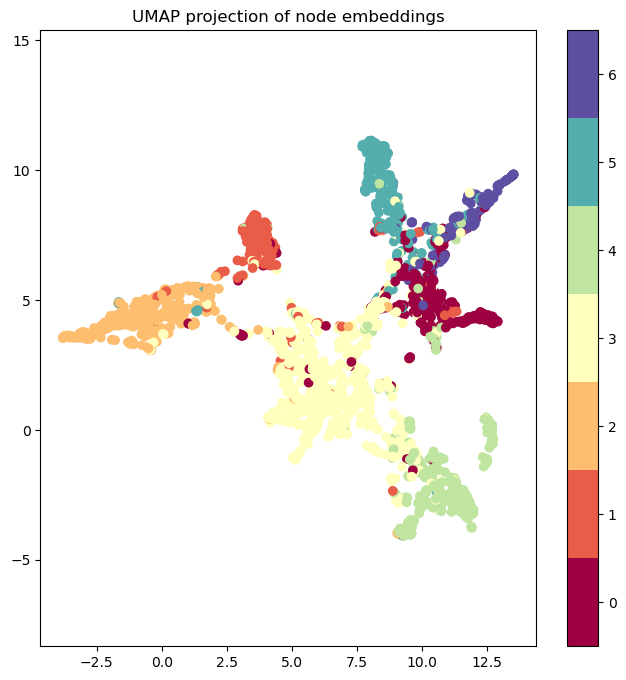

In [45]:
import umap 
import numpy as np
import matplotlib.pyplot as plt

# Get embeddings for test nodes
rng, new_rng = jax.random.split(state.rng)
node_embeddings, _, *att_coeffs = gat.apply(best_params, rng, test_data, is_training=False, return_att_coeffs=True)

# Use UMAP for dimensionality reduction
reducer = umap.UMAP(random_state=SEED)
node_embs_reduced = reducer.fit_transform(node_embeddings)

# Plot embeddings
plt.figure(figsize=(8, 8))
plt.scatter(node_embs_reduced[:, 0], node_embs_reduced[:, 1], c=test_data.labels, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(NUM_CLASSES+1)-0.5).set_ticks(np.arange(NUM_CLASSES))
plt.title('UMAP projection of node embeddings')

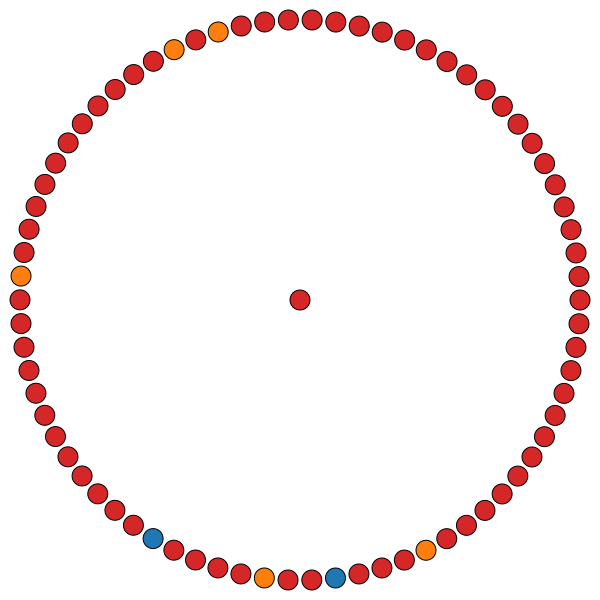

In [37]:
import igraph as ig

layer_index = 0
head_index = 0
node_index = 1701

# Get attention weights for specific layer, head and node
node_att_coeffs = att_coeffs[layer_index][head_index, node_index]

# Get weights and labels of attended nodes
attended_node_indices = jnp.nonzero(node_att_coeffs)[0]
attended_node_labels = test_data.labels.take(attended_node_indices)
attended_node_weights = node_att_coeffs.take(attended_node_indices)

# Create igraph for visualisation
graph = ig.Graph()
graph.add_vertices(len(attended_node_indices))
graph.add_edges([(i, 0) for i in range(len(attended_node_indices))])

graph_style = {
    'edge_width': attended_node_weights.tolist(),
    'vertex_color': [plt.get_cmap('tab10')(i) for i in attended_node_labels],
    'layout': graph.layout_reingold_tilford_circular()
}

ig.plot(graph, **graph_style)

Text(0.5, 1.0, 'Attention weights for node 1701')

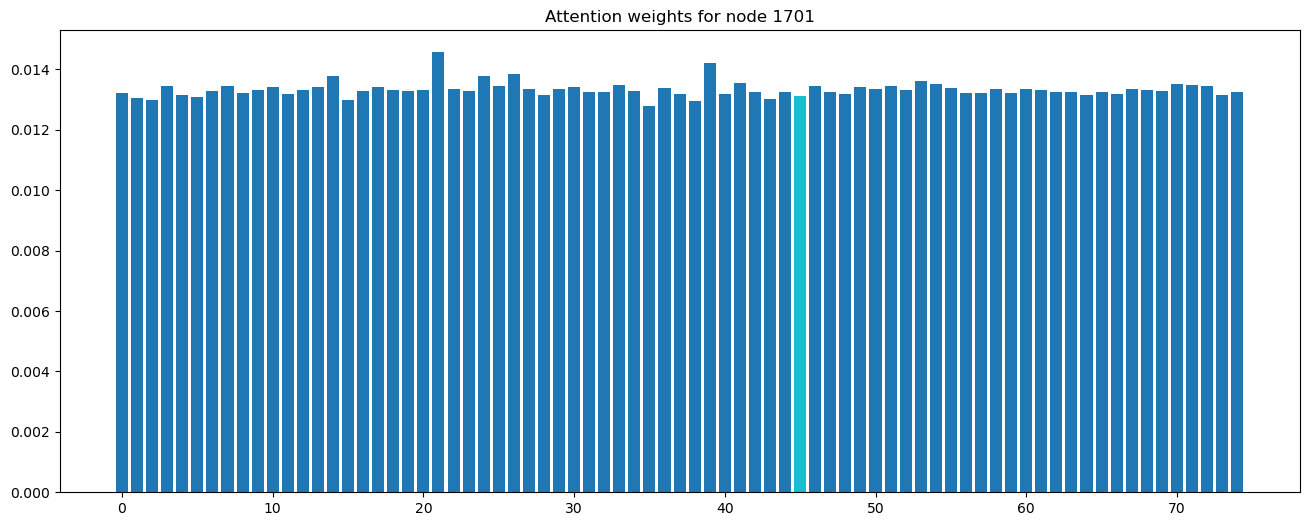

In [44]:
color_mask = np.zeros_like(attended_node_weights)
color_mask[np.where(attended_node_indices == node_index)] = 1

plt.figure(figsize=(16, 6))
plt.bar(range(len(attended_node_indices)), attended_node_weights, color=[plt.get_cmap('tab10')(i) for i in color_mask])
plt.title(f'Attention weights for node {node_index}')